# Principal Component Analysis (PCA) VS Linear Discriminant Analysis (LDA)

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg as sc
import math

## Data preparation

In [139]:
# Load the data in memory
data = pd.read_csv("data.csv")
print(data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [140]:
# COVERT THE DATAFRAME TO A MATRIX
# Transpose to get the desired representation
# (Each column represents an observation vector)
data = np.array(data)
data = data.T
print(data.shape)

(785, 42000)


In [141]:
# Split the data matrix in data (X) and labels (Y)
X = data[1:, :]
Y = data[0, :]
print(f"Labels: {Y}")

Labels: [1 0 1 ... 7 6 9]


In [142]:
# Get only the datapoints corresponding to a random number of digits 
# (0, 6 and 9) for example. 
# *It's the example of the pdf, maybe I am not really original hahahaha.

# Build a boolean matrix with the positions that we want to keep
datapoints = np.array(Y==1) + np.array(Y==2) + np.array(Y==7)# + np.array(Y==8)
X = X[:, datapoints]    # Select from each matrix the positions we want.
Y = Y[datapoints]

print(X.shape, Y.shape)

(784, 13262) (13262,)


In [143]:
def split_data(X, Y, Ntrain):
    """
    Given X and Y (Data and labels respectively), split the data into a 
    training and a test set. The number of observations in each will be
    determined by Ntrain.
    """

    d, N = X.shape

    # Create a vector with the indices of the data. Then shuffle it.
    idx = np.arange(N)
    np.random.shuffle(idx)

    # Get the respective indices for each set.
    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    # Now get both sets for each matrix.
    Xtrain = X[:, train_idx]
    Xtest = X[:, test_idx]

    Ytrain = Y[train_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

In [144]:
# Split the data into train and test sets.
d, N = X.shape
Ntrain = round(0.8 * N) # Take an 80% of the total data to do the training set.

Xtrain, Xtest, Ytrain, Ytest = split_data(X, Y, Ntrain)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(784, 10610) (10610,) (784, 2652) (2652,)


## Computation of the PCA

In [145]:
def pca(X: np.array, k: int):
    """
    Parameters:
        - X: Matrix of d x N dimensions.
        - k: Integer representing the dimension to truncate.

    Returns:
        - Z: The computed PCA of the matrix X.
    """

    d, N = X.shape

    # COMPUTE THE CENTERED VERSION OF X
    c = np.mean(X, axis=1)      # Get the centroid of the dataset
    c = np.reshape(c, (d, 1))   # Get the column vector of the centroid
    Xc = X - c                  # Perform the substraction

    # COMPUTE THE SVD OF Xc
    # Different of more than 30s when computing SVD with
    # full_matrices=False
    U, S, VT = np.linalg.svd(Xc, full_matrices=False)
    S = np.diag(S)

    # COMPUTE THE TRUNCATED VERSION OF THE SVD
    Uk = U[:, :k]
    Sk = S[:k, :k]
    VTk = VT[:k, :]
    Xck = Uk @ Sk @ VTk

    # COMPUTE THE PROJECTED DATASET Zk
    Zk = Uk.T @ Xc

    return Zk

## Computation of the LDA

In [146]:
def lda(X: np.array, Y: np.array, k: int):
    """
    Parameters:
        - X: Matrix of d x N dimensions.
        - Y: Vector of N labels.
        - k: Integer representing the dimension to truncate.

    Returns:
        - Z: The computed LDA of the matrix X.
    """

    d, N = X.shape          # Dimensions of the dataset
    ck = []                 # List of class centroids
    labels = np.unique(Y)   # Label of each class

    # COMPUTATION OF THE CLASS CENTROID
    # For each class of the problem compute its centroid
    for val in labels:
        idx = (Y==val)      # Indices of the datapoints corresponding to class k
        # Append to the list of class centroids the column vector of the class centroid
        ck.append(np.mean(X[:, idx], axis=1).reshape((d, 1)))

    # COMPUTATION OF THE GLOBAL CENTROID
    c = np.mean(X, axis=1).reshape((d, 1))

    # WITHING-CLUSTERS SCATTER MATRIX
    Xw = np.empty((d, N))        # Per-class centered matrix
    for i in range(len(labels)):
        idx = (Y==labels[i])
        Xc = X[:, idx] - c[i]
        Xw = np.concatenate((Xw, Xc), axis=1)

    Sw = Xw @ Xw.T

    # BETWEEN-CLUSTERS SCATTER MATRIX
    Xbar = np.empty((d, N))
    for i in range(len(labels)):
        idx = (Y==labels[i])
        Xbark = np.repeat(ck[i], X[:, idx].shape[1], axis=1)
        Xbar = np.concatenate((Xbar, Xbark), axis=1)

    Xbarc = Xbar - c
    Sb = Xbarc @ Xbarc.T

    # FINAL STEPS
    # if np.linalg.cholesky() raises error, the matrix is not definite positive
    try:
        L = np.linalg.cholesky(Sw)
    except: # If the matrix is not DP, the function raises an error
        eps = 1e-6
        I = np.eye(Sw.shape[0])

        # Make it definite positive
        Sw += eps*I

        L = np.linalg.cholesky(Sw)

    # Get the W matrix, whose column are the first k eigenvectors of L^-T Sb L^T
    # Note A^-T is the transpose of the inverse or the inverse of the transpose 
    # (Is the same)
    # np.linalg.eig doesn't return the eigenvalues in decreasing order, we will use
    # another function to compute the eigenvectors.
    Linv = np.linalg.inv(L)

    _, W = sc.eigs((Linv @ Sb @ L), k=k)
    W = np.real(W)

    # Here we are casting to real cause there is some sort of typo and the
    # resulting W is not real, but it should be, thats why we cast it.
    Q = Linv.T @ W

    # Compute the projection
    Z = Q.T @ X

    return Z


## Comparison of both algorithms
Notice for PCA we are not using the labels, that's why it's called "unsupervised learning technique"

### Computation of both projections

In [147]:
k = 50   # New dimension for the vectors
Z_pca = pca(Xtrain, k)
Z_lda = lda(Xtrain, Ytrain, k)

### Computation of centroids for both algorithms

In [148]:
# Compute the centroid for each cluster in PCA
ck_pca = []
labels = np.unique(Ytrain)
for val in labels:
    idx = (Ytrain==val)
    ck_pca.append(np.mean(Z_pca[:, idx], axis=1))

c_pca = np.mean(Z_pca, axis=1)

In [149]:
# Compute the centroid of each cluster in LDA
ck_lda = []
for val in labels:
    idx = (Ytrain==val)
    ck_lda.append(np.mean(Z_lda[:, idx], axis=1))

c_lda = np.mean(Z_lda, axis=1)

### Visualization of the results

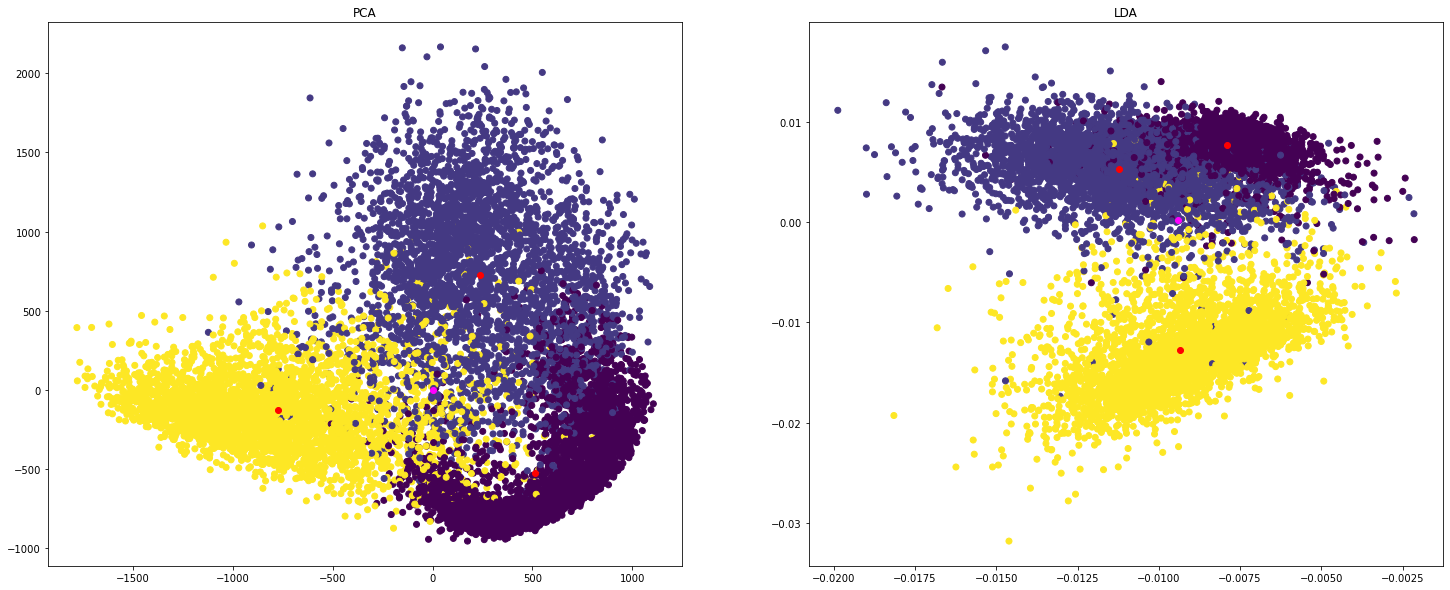

In [150]:
# VISUALIZE
plt.figure(figsize=(25, 10))

# SUBPLOT FOR PCA
plt.subplot(1, 2, 1)
plt.title("PCA")
plt.scatter(Z_pca[0, :], Z_pca[1, :], c=Ytrain)
# Plot the centroid of each cluster
for ck in ck_pca:
    plt.scatter(ck[0], ck[1], c="red")
plt.scatter(c_pca[0], c_pca[1], c="magenta")

# SUBPLOT FOR LDA
plt.subplot(1, 2, 2)
plt.title("LDA")
plt.scatter(Z_lda[0, :], Z_lda[1, :], c=Ytrain)
# Plot the centroid of each cluster
for ck in ck_lda:
    plt.scatter(ck[0], ck[1], c="red")
plt.scatter(c_lda[0], c_lda[1], c="magenta")

plt.show()

### Average distance from each cluster to the center

In [151]:
# Distances for PCA algorithm
dist_pca = []
for ck in ck_pca:
    # dist_pca.append(math.dist(ck, c_pca))
    dist_pca.append(np.linalg.norm(ck.reshape((k, 1)) - c_pca.reshape((k, 1)), 2)**2)

# Distances for LDA algorithm
dist_lda = []
for ck in ck_lda:
    # dist_lda.append(math.dist(ck, c_lda))
    dist_lda.append(np.linalg.norm(ck.reshape((k, 1)) - c_lda.reshape((k, 1)), 2)**2)

In [152]:
print("DISTANCES FOR PCA ALGORITHM:")
for i in range(len(labels)):
    print(f"\t- Distance from cluster labeled as {labels[i]} to the global center: {dist_pca[i] / sum(dist_pca)}")
    
print("DISTANCES FOR LDA ALGORITHM:")
for i in range(len(labels)):
    print(f"\t- Distance from cluster labeled as {labels[i]} to the global center: {dist_lda[i]}")

DISTANCES FOR PCA ALGORITHM:
	- Distance from cluster labeled as 1 to the global center: 0.3012202557209676
	- Distance from cluster labeled as 2 to the global center: 0.3421883332902584
	- Distance from cluster labeled as 7 to the global center: 0.35659141098877406
DISTANCES FOR LDA ALGORITHM:
	- Distance from cluster labeled as 1 to the global center: 0.00015169062306766415
	- Distance from cluster labeled as 2 to the global center: 0.00017447861200246118
	- Distance from cluster labeled as 7 to the global center: 0.00016841838317493036


## Testing on test dataset

In [153]:
# k = 6   # New dimension for the vectors
Z_pca = pca(Xtest, k)
Z_lda = lda(Xtest, Ytest, k)

In [154]:
# Compute the centroid for each cluster in PCA
ck_pca = []
labels = np.unique(Ytest)
for val in labels:
    idx = (Ytest==val)
    ck_pca.append(np.mean(Z_pca[:, idx], axis=1))

c_pca = np.mean(Z_pca, axis=1)

In [155]:
# Compute the centroid of each cluster in LDA
ck_lda = []
for val in labels:
    idx = (Ytest==val)
    ck_lda.append(np.mean(Z_lda[:, idx], axis=1))

c_lda = np.mean(Z_lda, axis=1)

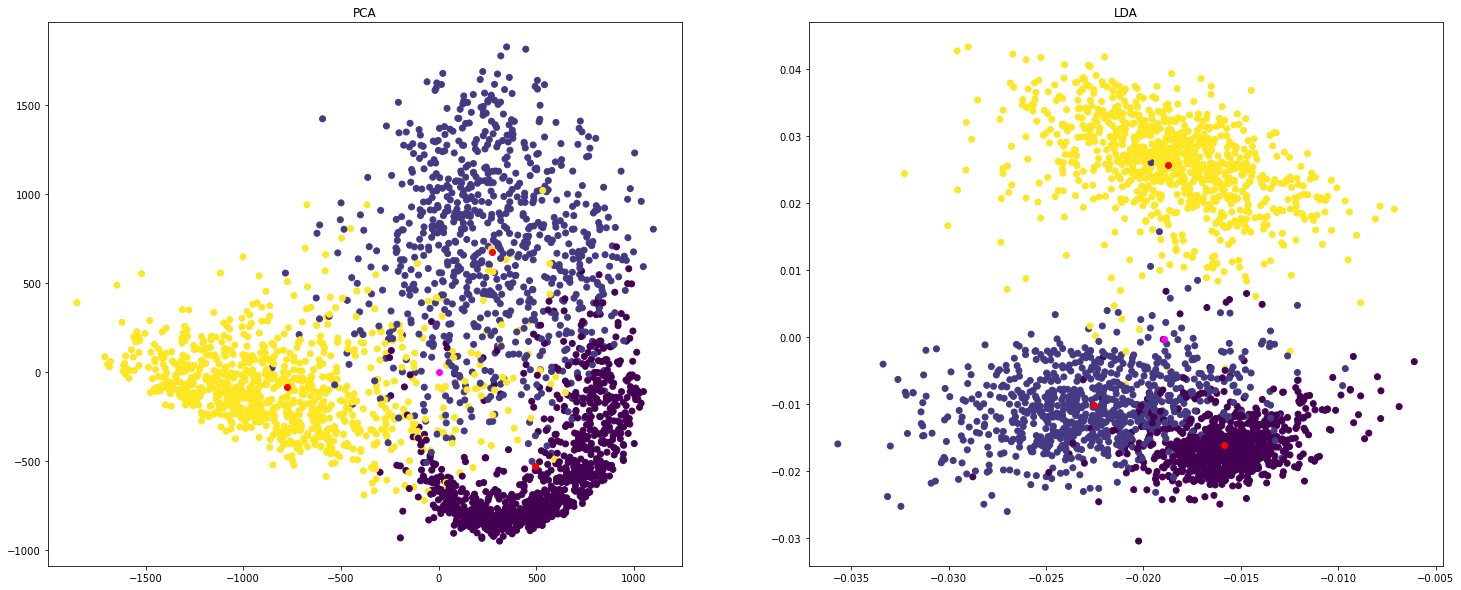

In [156]:
# VISUALIZE
plt.figure(figsize=(25, 10))

# SUBPLOT FOR PCA
plt.subplot(1, 2, 1)
plt.title("PCA")
plt.scatter(Z_pca[0, :], Z_pca[1, :], c=Ytest)
# Plot the centroid of each cluster
for ck in ck_pca:
    plt.scatter(ck[0], ck[1], c="red")
plt.scatter(c_pca[0], c_pca[1], c="magenta")

# SUBPLOT FOR LDA
plt.subplot(1, 2, 2)
plt.title("LDA")
plt.scatter(Z_lda[0, :], Z_lda[1, :], c=Ytest)
# Plot the centroid of each cluster
for ck in ck_lda:
    plt.scatter(ck[0], ck[1], c="red")
plt.scatter(c_lda[0], c_lda[1], c="magenta")

plt.show()

In [157]:
# Distances for PCA algorithm
dist_pca = []
for ck in ck_pca:
    # dist_pca.append(math.dist(ck, c_pca))
    dist_pca.append(np.linalg.norm(ck.reshape((k, 1)) - c_pca.reshape((k, 1)), 2)**2)

# Distances for LDA algorithm
dist_lda = []
for ck in ck_lda:
    # dist_lda.append(math.dist(ck, c_lda))
    dist_lda.append(np.linalg.norm(ck.reshape((k, 1)) - c_lda.reshape((k, 1)), 2)**2)

In [158]:
print("DISTANCES FOR PCA ALGORITHM:")
for i in range(len(labels)):
    print(f"\t- Distance from cluster labeled as {labels[i]} to the global center: {dist_pca[i] / sum(dist_pca)}")
    
print("DISTANCES FOR LDA ALGORITHM:")
for i in range(len(labels)):
    print(f"\t- Distance from cluster labeled as {labels[i]} to the global center: {dist_lda[i]}")

DISTANCES FOR PCA ALGORITHM:
	- Distance from cluster labeled as 1 to the global center: 0.30605567189681143
	- Distance from cluster labeled as 2 to the global center: 0.32965701059179675
	- Distance from cluster labeled as 7 to the global center: 0.36428731751139193
DISTANCES FOR LDA ALGORITHM:
	- Distance from cluster labeled as 1 to the global center: 0.0006285237426792831
	- Distance from cluster labeled as 2 to the global center: 0.0007307833599360365
	- Distance from cluster labeled as 7 to the global center: 0.0006845028855626889


## Definition of a classification algorithm

In [159]:
def classify(X: np.array, centroids: np.array, labels):
    """
    Given an array of datapoints and array of centroids, classify each datapoint
    to the closest centroid.

    Parameters:
        - X: Array of datapoints to be classify.
        - centroids: Array of vectors, each one, the centroid of a possible cluster.
          Assume the centroids are column vectors
        - labels: Vector with the possible labels
    Returns:
        - Y: Array of corresponding labels to each datapoints.
    """

    # Always get first the dimensions of our problems 
    # (d = Dimension of the points)
    # (N = Number of datapoints on the set)
    d, N = X.shape
    k = len(labels) # The number of classes is the same as the number of centroids

    # Structure for the solution of our problem.
    Y = np.empty((N, ))

    for i in range(N):
        d = X[:, i]      # Save the datapoint we are goint to evaluate in a variable
        minDist = np.Inf # Actual minimun distance (Set to infiniy, there will be always something less)
        labelId = 0
        for j in range(k): # Evaluate the distance of d to each centroid
            newDist = np.linalg.norm(d - centroids[j], 2)**2 # Compute the distance from datapoint to centroid
            if newDist < minDist:
                minDist = newDist   # Update if is less than the last one.
                labelId = j         # Update the label of the datapoint

        Y[i] = labels[labelId]      # Assign the label to the datapoint.
            
    return Y

In [160]:
Ypredict_pca = classify(Z_pca, ck_pca, labels)
Ypredict_lda = classify(Z_lda, ck_lda, labels)

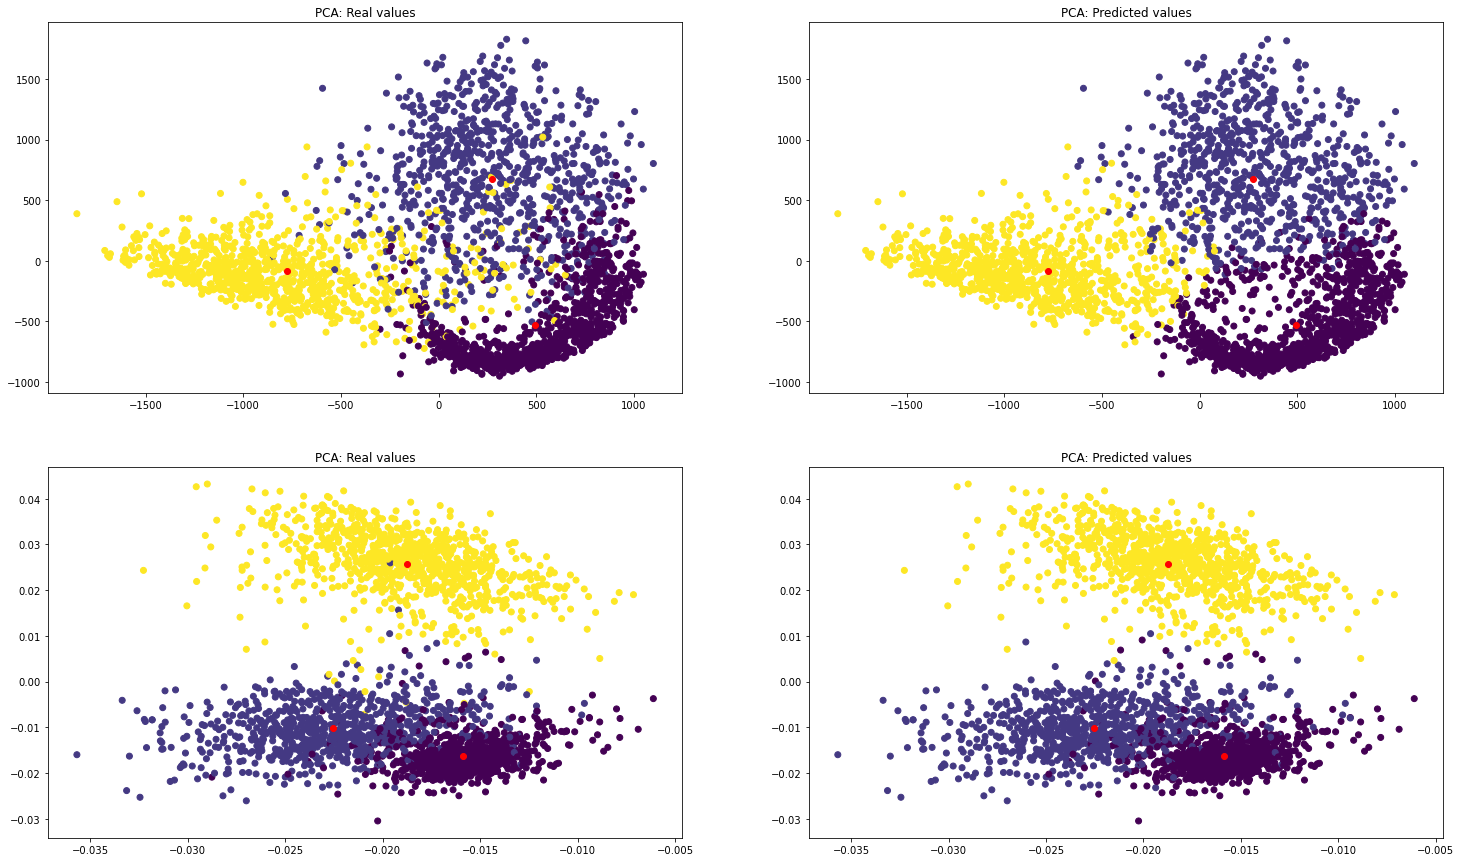

In [161]:
# VISUALIZE
plt.figure(figsize=(25, 15))

# SUBPLOT FOR PCA'S REAL VALUES
plt.subplot(2, 2, 1)
plt.title("PCA: Real values")
plt.scatter(Z_pca[0, :], Z_pca[1, :], c=Ytest)
# Plot the centroid of each cluster
for ck in ck_pca:
    plt.scatter(ck[0], ck[1], c="red")

# SUBPLOT FOR PCA'S PREDICTED VALUES
plt.subplot(2, 2, 2)
plt.title("PCA: Predicted values")
plt.scatter(Z_pca[0, :], Z_pca[1, :], c=Ypredict_pca)
# Plot the centroid of each cluster
for ck in ck_pca:
    plt.scatter(ck[0], ck[1], c="red")

# SUBPLOT FOR LDA'S REAL VALUES
plt.subplot(2, 2, 3)
plt.title("PCA: Real values")
plt.scatter(Z_lda[0, :], Z_lda[1, :], c=Ytest)
# Plot the centroid of each cluster
for ck in ck_lda:
    plt.scatter(ck[0], ck[1], c="red")

# SUBPLOT FOR LDA'S PREDICTED VALUES
plt.subplot(2, 2, 4)
plt.title("PCA: Predicted values")
plt.scatter(Z_lda[0, :], Z_lda[1, :], c=Ypredict_lda)
# Plot the centroid of each cluster
for ck in ck_lda:
    plt.scatter(ck[0], ck[1], c="red")

plt.show()

## Evaluation of the accuracy

In [162]:
Ntest = len(Ytest)

correctVals_pca = sum(Ypredict_pca == Ytest)
correctVals_lda = sum(Ypredict_lda == Ytest)

acc_pca = round((correctVals_pca / Ntest)*100, 2)
acc_lda = round((correctVals_lda / Ntest)*100, 2)
print(acc_pca)
print(acc_lda)

92.57
98.76


## Repetition of the experiment with different k and digits

### Digits: [0, 6, 9]
Accuracy results (k=2):
- MLE: 82.5
- MAP: 84.95

Accuracy results (k=6):
- MLE: 92.23
- MAP: 99.1

Accuracy results (k=10):
- MLE: 92.84
- MAP: 99.28

Accuracy results (k=20):
- MLE: 93.51
- MAP: 99.06

Accuracy results (k=50):
- MLE: 92.65
- MAP: 98.64

### Digits [1, 2, 7] | k = 2
Accuracy results:
- 89.89
- 92.23

### Digits [3, 4, 5, 8] | k = 2
Accuracy results:
- 58.35
- 78.69

### Digits [1, 2, 7] | k = 4
Accuracy results:
- 89.93
- 93.25

### Digits [3, 4, 5, 8] | k = 4
Accuracy results:
- 59.03
- 80.13

# Visualizing Dyad

In [163]:
# Load the data in memory
data = pd.read_csv("data.csv")
data = np.array(data)
data = data.T
X = data[1:, :]
Y = data[0, :]

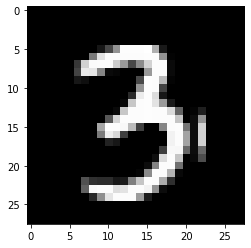

In [164]:
img = X[:, 8007].reshape((28, 28))
plt.imshow(img, cmap="gray")
plt.show()

In [165]:
U, S, VT = np.linalg.svd(img, full_matrices=False)

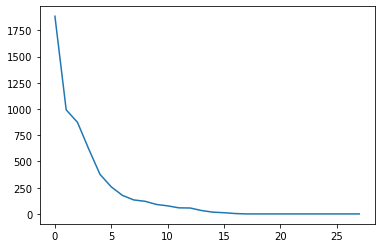

In [166]:
plt.plot(S)
plt.show()

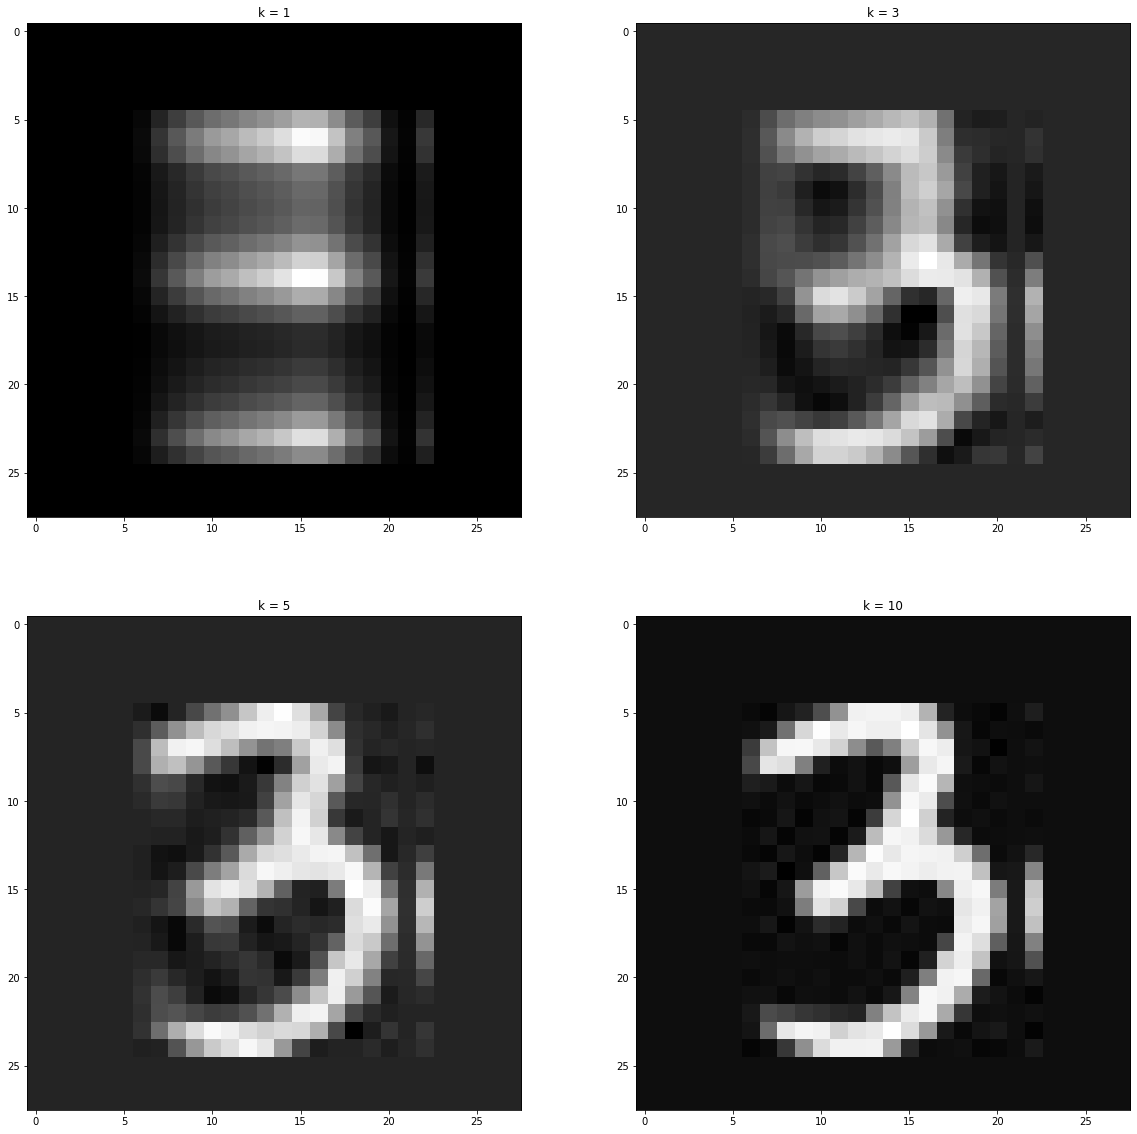

In [167]:
ki = [1, 3, 5, 10]
approx = []

for k in ki:

    Xk = np.zeros((28,28))

    # COMPUTE THE TRUNCATED VERSION BY SUMMING OF DYADS
    for i in range(k):
        ui = U[:, i].reshape((-1, 1))
        vti = VT[i, :].reshape((1, -1))

        Xk += S[i]*ui@vti

    approx.append(Xk)

plt.figure(figsize=(20, 20))
for i in range(len(ki)):
    plt.subplot(2, 2, i+1)
    plt.title(f"k = {ki[i]}")
    plt.imshow(approx[i], cmap="gray")
plt.show()

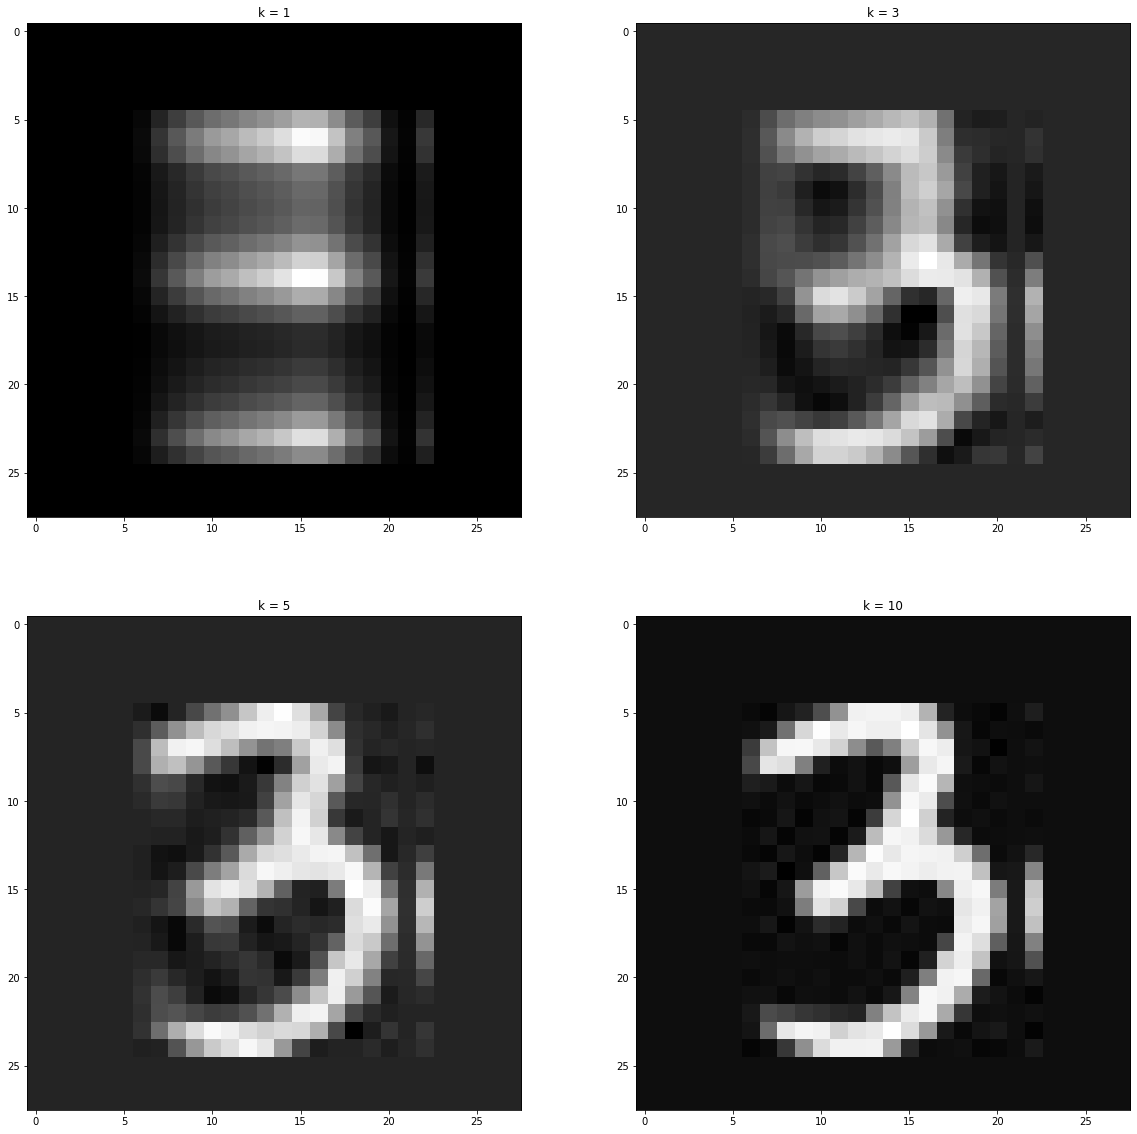

In [168]:
ki = [1, 3, 5, 10]
approx = []
S = np.diag(S)

for k in ki:
    # COMPUTE THE TRUNCATED VERSION OF THE SVD
    Uk = U[:, :k]
    Sk = S[:k, :k]
    VTk = VT[:k, :]
    Xk = Uk @ Sk @ VTk

    approx.append(Xk)

plt.figure(figsize=(20, 20))
for i in range(len(ki)):
    plt.subplot(2, 2, i+1)
    plt.title(f"k = {ki[i]}")
    plt.imshow(approx[i], cmap="gray")
plt.show()

In [172]:
error = []
for i in range(len(ki)):
    error.append(np.linalg.norm((img - approx[i]), 2))
    print(f"Error for k = {ki[i]}: {error[i]}")

Error for k = 1: 991.5253671476107
Error for k = 3: 618.2294107244527
Error for k = 5: 257.4277890767098
Error for k = 10: 76.7905831739854


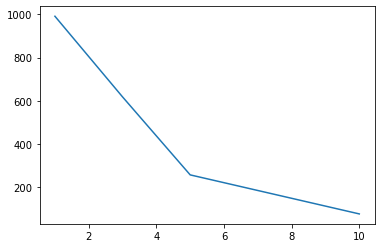

In [173]:
plt.plot(ki, error)
plt.show()

In [171]:
m, n = img.shape
for i in range(len(ki)):
    print(f"Compression factor of k = {ki[i]}: {round(ki[i]/min(m,n)*100, 2)}%")

Compression factor of k = 1: 3.57%
Compression factor of k = 3: 10.71%
Compression factor of k = 5: 17.86%
Compression factor of k = 10: 35.71%
